# Spike count trials regression

### Table of contents

1. [**Synthetic heteroscedastic count data**](#data)
2. [**Model recovery**](#recover)
3. [**Fitting the UCM**](#fit)
4. [**Evaluating the UCM**](#eval)


In [1]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")


import neuroprob as nprb
from neuroprob import utils
from neuroprob.likelihoods.discrete import gen_NB


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.13.0+cu117
Using device: cuda:0


<a id="synthetic"></a>
## 1. Synthetic heteroscedastic count data

In [2]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]


In [3]:
trial_len = 100
trials = 100
conds = 1

# angular stimulus presentations
angle_tr = np.empty((conds, trials, trial_len))

angles = np.linspace(0, 2*np.pi, conds+1)[:-1]
for c in range(conds):
    for tr in range(trials):
        angle_tr[c, tr, :] = angles[c]

In [4]:
tbin = 0.05
neurons = 50
rng = np.random.default_rng(123)  # seed RNG

# von Mises fields
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

_angle_0 = rng.permutation(p_z)
_beta = (0.2 * rng.normal(size=(neurons,)))**2 + 0.01
_rate_0 = rng.uniform(size=(neurons,)) * 30.0
_b = rng.uniform(size=(neurons,)) * 1.

# rate tuning curve
vm_rate = lambda x: HDC_bumps(x, p_a, p_b, p_c, p_z)

# dispersion tuning curve
vm_disp = lambda x: HDC_bumps(x, _rate_0, 1e6 * np.ones_like(1./_beta), _b, _angle_0)

In [5]:
steps = 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

rate = vm_rate(covariates)
r = vm_disp(covariates)

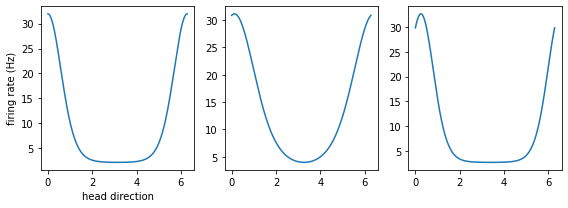

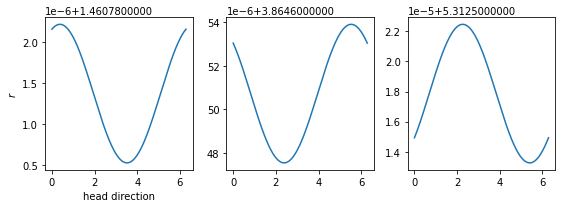

In [6]:
fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, rate[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')
    
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, r[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$r$')
    
fig.tight_layout()
plt.show()

In [7]:
# generate data
angle_t = angle_tr.flatten()
timesamples = len(angle_t)

rate_t = vm_rate(angle_t)
r_t = vm_disp(angle_t)

syn_train = gen_NB(rng, rate_t*tbin, r_t)
max_count = syn_train.max()
syn_train_tr = syn_train.reshape(neurons, conds, trials, trial_len)

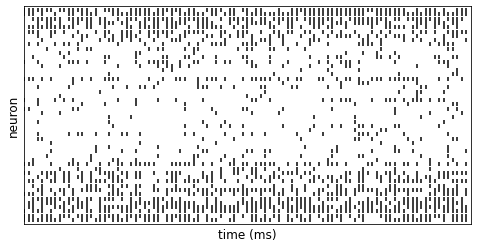

In [8]:
T = 100

fig, ax = plt.subplots(figsize=(8,4))
utils.plots.raster_plot((fig, ax), syn_train[:, :T], T, tbin*1000, neurons, markersize=10)
utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()

<a id="fit"></a>
## 3. Fitting the UCM


In [9]:
C = 3
out_dims = C*neurons

# kernel
l = 2.*torch.ones(1, out_dims)
v = 1.*torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='ring', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
input_data = [torch.from_numpy(angle_t)]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, timesamples, batch_info=5000)

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(out_dims, torch.from_numpy(Xu))


# mapping
in_dims = Xu.shape[-1]

gp = nprb.mappings.SVGP(
    in_dims, out_dims, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(out_dims), learn_mean=True
)

# likelihood
basis_mode = 'el'  # exponential-linear
likelihood = nprb.likelihoods.discrete.Universal(neurons, C, basis_mode, 'identity', max_count)
likelihood.set_Y(torch.from_numpy(syn_train), batch_info=5000) 

# assemble
gpr = nprb.inference.VI_optimized(input_group, gp, likelihood)
gpr.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Universal(
    (lsoftm): LogSoftmax(dim=-1)
    (mapping_net): Parallel_Linear(in_features=6, out_features=4, channels=50, bias=True)
  )
)

In [10]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.99)
opt_lr_dict = {
    'default': 1e-2, 
}

gpr.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gpr.fit(3000, loss_margin=-1e1, margin_epochs=30, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 135.


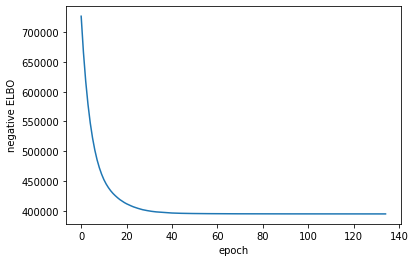

In [11]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='eval'></a>
## 4. Evaluating the UCM


In [12]:
def get_q_Z(P, spike_binned):
    deq_noise = np.random.uniform(size=spike_binned.shape)

    cumP = np.cumsum(P, axis=-1)  # T, K
    tt = np.arange(spike_binned.shape[0])
    quantiles = (
        cumP[tt, spike_binned.astype(int)] - P[tt, spike_binned.astype(int)] * deq_noise
    )
    Z = utils.stats.q_to_Z(quantiles)
    return quantiles, Z

<a id='eval_fit'></a>
### 4.1 Goodness-of-fit metrics
Apart from the likelihood score, a more direct measure of goodness-of-fit is given by the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) adapted to count distributions. We compute the predictive spike count distribution given input covariates and then compute the quantiles of the observed spike counts. These are obtained from the training data, and will thus show us how well the model was able to fit in an absolute sense. We can turn these into $Z$-scores (which will be unit normal distributed if the model describes observations well).

In [13]:
# quantiles, Z scores
P_ = []
for b in range(gpr.input_group.batches):
    covariates, _ = gpr.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = utils.model.compute_UCM_P_count(gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(neurons):
    batch_edge, _, _ = gpr.likelihood.batch_info
    spike_binned = gpr.likelihood.all_spikes[trial, n, :].numpy()
    q_, Z_ = get_q_Z(P[n, ...], spike_binned)
    q.append(q_)
    Z.append(Z_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)
Z = np.array(Z)  # Z scores of shape (neurons, timesteps)

We can obtain the Kolmogorov-Smirnov test statistic $T_{KS}$, and the dispersion statistic $T_{DS}$ as well (see paper). These statistics are computed per neuron and reflect single neuron goodness-of-fit measures. The $T_{KS}$ statistic seems to be roughly distributed as the sampling distribution under the null model, i.e. if the model generated the data this would be the distribution of $T_{KS}$ observed for an infinite number of repetitions of random data draws.

In [14]:
T_DS_bn = []
T_KS_bn = []
for qq in q:
    T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_statistics(qq, alpha=0.05, alpha_s=0.05)
    T_DS_bn.append(T_DS)
    T_KS_bn.append(T_KS)

T_DS_bn = np.array(T_DS_bn)  # (neurons,)
T_KS_bn = np.array(T_KS_bn)


x = np.linspace(0, 0.05, 100)
bins = np.linspace(0, 0.05, 50)
f = utils.stats.KS_sampling_dist(x, len(q[0]))

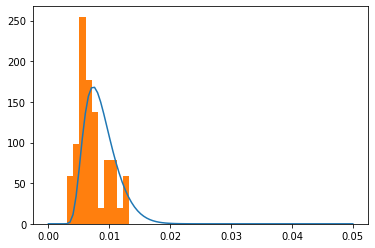

In [15]:
plt.plot(x, f)
plt.hist(T_KS_bn, bins=bins, density=True)
plt.show()

<a id='SCD'></a>
### 4.2 Computing spike count distributions

We can compute the spike count distribution conditioned on input covariates, and in this way we can explore the neural tuning over a slice through input space. We set all other covariates at the mean values of the observed time series in the dataset.

In [16]:
covariates = torch.from_numpy(angles)[None, None, :, None]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = utils.model.compute_UCM_P_count(
        gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior

P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)
lower, median, upper = utils.stats.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])

# true parameters
rate = vm_rate(angles)
r = vm_disp(angles)

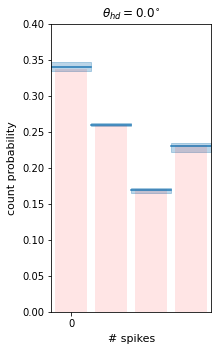

In [17]:
ne = 0  # select neuron to plot


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

for en, cond_ind in enumerate([0]):
    ax = fig.add_subplot(spec[0, en])
    ang = angles[cond_ind]
    
    # true count distribution
    bins = np.arange(max_count+1)
    gt_P = utils.stats.nb_count_prob(
        bins, rate[ne, cond_ind], 1/r[ne, cond_ind], tbin)
    emp_P, _ = np.histogram(syn_train_tr[ne, cond_ind].flatten(), 
                            bins=np.arange(max_count+2), density=True)
    
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(ang / np.pi * 180) + r'$^{\circ}$')
    for k in range(max_count+1):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2) * median.numpy()[ne, cond_ind, k]
        YY_l = np.ones(2) * lower.numpy()[ne, cond_ind, k]
        YY_u = np.ones(2) * upper.numpy()[ne, cond_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)
        
        ax.bar(XX_[0]+0.5, gt_P[k], color='k', alpha=0.1)
        ax.bar(XX_[0]+0.5, emp_P[k], color='r', alpha=0.1)


    ax.set_xlim([-0.5, max_count+.5])
    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(max_count+1)[::5])
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)

plt.show()